In [ ]:
# importing files from google colab
from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


In [ ]:
# here we delete the files in the specified path
import os

folder_path = "/content/x"  # Replace "folder_name" with the actual folder name

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Iterate over the files and delete them
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    os.remove(file_path)


In [ ]:
# this code deletes a specific amount of files from a path
import os

folder_path = "/content/folder_name"  # Replace "folder_name" with the actual folder name
num_files_to_delete = 10  # Replace with the desired number of files to delete

# Get the list of files in the folder
file_list = os.listdir(folder_path)

# Counter for tracking the number of files deleted
files_deleted = 0

# Iterate over the files and delete up to the specified number
for file_name in file_list:
    if files_deleted >= num_files_to_delete:
        break

    file_path = os.path.join(folder_path, file_name)
    os.remove(file_path)
    files_deleted += 1


In [ ]:
# code to check image size
from PIL import Image

image = Image.open(r"/content/x/stamp0_angle-12_doc6_pos0_noise3_sdarkness1_bdarkness3_doc28515.png")
width, height = image.size

print("Image size: {} x {}".format(width, height))


Image size: 754 x 1000


In [ ]:

# code to generate a 45k dateset of documents with one stamp and a dataset with the extracted stamps and retruns a list of the coordinates of the stamp
# this code is very important to train the model on
# this code and all other data generation codes down can be modifies to give different number of documents with more stamps
import os.path

import cv2
import numpy as np
import glob
import random
import re
def remove_random_pixels(image, num, how_many=350):
    height, width = image.shape
    num_pixels = how_many * num  # Randomly choose the number of pixels to remove

    for _ in range(num_pixels):
        x = random.randint(0, width - 1)  # Random x-coordinate
        y = random.randint(0, height - 1)  # Random y-coordinate
        image[y, x] = 255  # Set the pixel at (x, y) to white (255)

    return image
def insert_stamps(stamps_folder, documents_folder, output_folder, threshold, scale_factor):
    # Get the list of stamp image paths
    # Before the loop starts, create an empty list to store the coordinates
    stamp_coordinates = []
    stamp_paths = glob.glob(stamps_folder + "/*.png")
    stamp_paths = sorted(stamp_paths, key=lambda x: (len(x), x))
    # Get the list of document image paths
    document_paths = glob.glob(documents_folder + "/*.jpg")
    document_paths = sorted(document_paths, key=lambda x: (len(x), x))
    doc_number=0
    # Iterate over each document image
    for doc_num, document_path in enumerate(document_paths):
        # Load the document image
        document_img = cv2.imread(document_path, cv2.IMREAD_GRAYSCALE)
        for darknes in range(3):
            random_background_darkness=random.randint(0,70)
            document_img = np.where(document_img<50,random_background_darkness,document_img)
            # Get the dimensions of the document image
            doc_height, doc_width = document_img.shape
            stamp_num="osama"
            # Iterate over each stamp image
            for stamp_path in stamp_paths:
                # stamp_path = random.choice(stamp_paths)
                stamp_num=os.path.basename(stamp_path)
                stamp_num=stamp_num[0:-4]
                print(stamp_num)
                # Load the stamp image
                stamp_img = cv2.imread(stamp_path, cv2.IMREAD_GRAYSCALE)
                stamp_img = np.where(stamp_img<50,darknes*50,stamp_img)
                # Resize the stamp image
                resized_stamp = cv2.resize(stamp_img, None, fx=scale_factor, fy=scale_factor)

                # Iterate over different rotations (0 to 360 degrees)
                iter=0
                for angle in range(0,300,60):
                    angle = random.randint(angle-60,angle+60)
                    # Rotate the stamp image with border fill
                    rotation_matrix = cv2.getRotationMatrix2D((resized_stamp.shape[1]//2, resized_stamp.shape[0]//2), angle, 1)
                    rotated_stamp = cv2.warpAffine(resized_stamp, rotation_matrix, (resized_stamp.shape[1], resized_stamp.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(255))
                    for level_of_noise in range(4):
                        rotated_stamp = remove_random_pixels(rotated_stamp, level_of_noise, 600)
                        # Find the black pixels in the rotated stamp image
                        black_pixels = (rotated_stamp < threshold)

                        # Iterate over 20 different positions within the document image
                        for _ in range(5):
                            # Randomly select x, y coordinates for stamp insertion
                            x = random.randint(0, doc_width - rotated_stamp.shape[1])
                            y = random.randint(0, doc_height - rotated_stamp.shape[0])

                            # Create a copy of the document image
                            result_img = document_img.copy()

                            # Get the coordinates to insert the stamp image
                            y_start, y_end = y, y + rotated_stamp.shape[0]
                            x_start, x_end = x, x + rotated_stamp.shape[1]

                            # Replace the pixels in the document image with the black pixels from the rotated stamp
                            result_img[y_start:y_end, x_start:x_end][black_pixels] = 0

                            # Save the modified image with a descriptive name
                            # output_name = output_folder + r"\d\doc{}_stamp{}_angle{}_pos{}.png".format(doc_num, stamp_num, angle // 30, _)

                            output_name = output_folder + r"/x/stamp{}_angle{}_doc{}_pos{}_noise{}_sdarkness{}_bdarkness{}_doc{}.png".format(stamp_num,angle,doc_num,_ ,level_of_noise,darknes,random_background_darkness,doc_number)

                            cv2.imwrite(output_name, result_img)

                            # Extract the area with the stamp from the final image
                            stamp_area = result_img[y_start:y_end, x_start:x_end]
                            # for level_of_noise in range(4):
                            #     stamp_area=remove_random_pixels(stamp_area,level_of_noise,600)
                                # Save the extracted area with the stamp
                            extracted_name = output_folder + r"/y/stamp{}_angle{}_doc{}_pos{}_noise{}_sdarkness{}_bdarkness{}_doc{}.png".format(stamp_num,angle,doc_num,_ ,level_of_noise,darknes,random_background_darkness,doc_number)
                            cv2.imwrite(extracted_name, stamp_area)
                            doc_number+=1
                            print(extracted_name, x_start, y_start, x_end, y_end)
                            stamp_coordinates.append((x_start, y_start, x_end, y_end))
    return stamp_coordinates

# Specify the folder paths
stamps_folder = r"/content/drive/MyDrive/Final_Images"
documents_folder = r"/content/drive/MyDrive/docs"
output_folder = r"/content"

# Specify the threshold for black color (0-255 range)
threshold = 150

# Specify the scale factor for resizing the stamp image
scale_factor = 0.3

# Call the function
list_of_coordinates=insert_stamps(stamps_folder, documents_folder, output_folder, threshold, scale_factor)


0
/content/y/stamp0_angle-6_doc0_pos0_noise0_sdarkness0_bdarkness69_doc0.png 179 236 333 390
/content/y/stamp0_angle-6_doc0_pos1_noise0_sdarkness0_bdarkness69_doc1.png 223 286 377 440
/content/y/stamp0_angle-6_doc0_pos2_noise0_sdarkness0_bdarkness69_doc2.png 604 21 758 175
/content/y/stamp0_angle-6_doc0_pos3_noise0_sdarkness0_bdarkness69_doc3.png 240 526 394 680
/content/y/stamp0_angle-6_doc0_pos4_noise0_sdarkness0_bdarkness69_doc4.png 120 676 274 830
/content/y/stamp0_angle-6_doc0_pos0_noise1_sdarkness0_bdarkness69_doc5.png 310 596 464 750
/content/y/stamp0_angle-6_doc0_pos1_noise1_sdarkness0_bdarkness69_doc6.png 525 265 679 419
/content/y/stamp0_angle-6_doc0_pos2_noise1_sdarkness0_bdarkness69_doc7.png 188 813 342 967
/content/y/stamp0_angle-6_doc0_pos3_noise1_sdarkness0_bdarkness69_doc8.png 183 107 337 261
/content/y/stamp0_angle-6_doc0_pos4_noise1_sdarkness0_bdarkness69_doc9.png 194 770 348 924
/content/y/stamp0_angle-6_doc0_pos0_noise2_sdarkness0_bdarkness69_doc10.png 446 367 600 5

KeyboardInterrupt: ignored

In [ ]:
print(len(list_of_coordinates))

45000


In [ ]:
# this code is to check the number of files in a certain path to make sure the generation was okay

import os

def count_files_in_folder(folder_path):
    file_count = 0

    for _, _, files in os.walk(folder_path):
        file_count += len(files)

    return file_count

# Provide the folder path
folder_path = '/content/y'

# Call the function to get the file count
num_files = count_files_in_folder(folder_path)

# Print the number of files
print("Number of files in the folder:", num_files)


Number of files in the folder: 45000


In [ ]:
# import os

# first_path = '/content/x'
# second_path = '/content/generated_documents'
# third_path = '/content/augmented_documents'
# x_file_paths = []
# for root, dirs, files in os.walk(first_path):
#     for file in files:
#         x_file_path = os.path.join(root, file)
#         x_file_paths.append(x_file_path)
# for root, dirs, files in os.walk(second_path):
#     for file in files:
#         x_file_path = os.path.join(root, file)
#         x_file_paths.append(x_file_path)
# for root, dirs, files in os.walk(third_path):
#     for file in files:
#         x_file_path = os.path.join(root, file)
#         x_file_paths.append(x_file_path)


# print(len(x_file_paths))

45388


In [ ]:
# sort the data by the last number in the name
import re
x_file_paths = sorted(x_file_paths, key=lambda x_file_paths: int(re.search(r"(\d+)\.png$", x_file_paths).group(1)) if re.search(r"(\d+)\.png$", x_file_paths) else float('inf'))


In [ ]:
# set labels as 1 or 0 for images with and without stamps for the model that predicts if their is a stamp or not
lables=[]
labels=[1 if i<45000 else 0 for i in range(61206)]

In [ ]:
labels[4000]

1

In [ ]:
# randomize the images and their labels(cords of stamps) with the same randomization so that each two corresponding elements stay corresponding
# this is for the model that predicts the coordinates of the stamp on the image
import random

# Combine the two lists using zip()
combined = list(zip(list_of_coordinates, x_file_paths))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list back into separate lists
list_of_coordinates, x_file_paths = zip(*combined)

print(list_of_coordinates[15:100])
print(x_file_paths[15:100])



((596, 96, 750, 250), (21, 469, 175, 623), (579, 1, 733, 155), (195, 316, 349, 470), (210, 656, 364, 810), (231, 277, 385, 431), (203, 73, 357, 227), (8, 348, 162, 502), (27, 9, 181, 163), (359, 266, 513, 420), (459, 598, 613, 752), (399, 634, 553, 788), (384, 344, 538, 498), (495, 721, 649, 875), (535, 221, 689, 375), (433, 485, 587, 639), (526, 662, 680, 816), (187, 307, 341, 461), (13, 785, 167, 939), (307, 208, 461, 362), (196, 623, 350, 777), (116, 120, 270, 274), (116, 368, 270, 522), (168, 614, 322, 768), (449, 353, 603, 507), (397, 144, 551, 298), (303, 818, 457, 972), (269, 334, 423, 488), (481, 150, 635, 304), (444, 486, 598, 640), (392, 712, 546, 866), (41, 102, 195, 256), (113, 465, 267, 619), (193, 48, 347, 202), (91, 479, 245, 633), (187, 537, 341, 691), (95, 318, 249, 472), (400, 272, 554, 426), (284, 36, 438, 190), (346, 581, 500, 735), (53, 5, 207, 159), (86, 48, 240, 202), (370, 644, 524, 798), (52, 404, 206, 558), (297, 436, 451, 590), (106, 584, 260, 738), (603, 177

In [ ]:
# same but for the model that predicts if there is a stamp or not
import random

# Combine the two lists using zip()
combined = list(zip(labels, x_file_paths))

# Shuffle the combined list
random.shuffle(combined)

# Unzip the shuffled list back into separate lists
labels, x_file_paths = zip(*combined)

print(labels[:10])
print(x_file_paths[:10])



(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
('/content/x/stamp12_angle218_doc6_pos1_noise0_sdarkness1_bdarkness3_doc29761.png', '/content/x/stamp8_angle104_doc7_pos0_noise0_sdarkness0_bdarkness64_doc32340.png', '/content/x/stamp12_angle76_doc4_pos1_noise2_sdarkness2_bdarkness56_doc22251.png', '/content/x/stamp4_angle-52_doc5_pos4_noise2_sdarkness1_bdarkness22_doc24414.png', '/content/x/stamp9_angle164_doc4_pos2_noise1_sdarkness2_bdarkness56_doc21967.png', '/content/x/stamp7_angle-19_doc5_pos1_noise2_sdarkness2_bdarkness27_doc26211.png', '/content/x/stamp14_angle105_doc3_pos0_noise1_sdarkness2_bdarkness38_doc17945.png', '/content/x/stamp11_angle-9_doc0_pos0_noise0_sdarkness0_bdarkness22_doc1100.png', '/content/x/stamp14_angle183_doc9_pos1_noise2_sdarkness2_bdarkness28_doc44991.png', '/content/x/stamp9_angle225_doc8_pos2_noise0_sdarkness2_bdarkness69_doc39962.png')


In [ ]:
# code to generate a dataset of documents without stamps on and with random text
import os
from PIL import Image, ImageDraw, ImageFont
import random
import string
import textwrap

output_directory = "/content/generated_documents"
os.makedirs(output_directory, exist_ok=True)

num_documents = 30000
image_width = 600
image_height = 800
background_color = (255, 255, 255)  # White background
text_color = (0, 0, 0)  # Black text color
min_words = 200
max_words = image_width * image_height * 0.95 // 100  # Maximum number of words to fill 95% of the document

# Generate and save the documents
for i in range(num_documents):
    # Create a blank image with white background
    image = Image.new("RGB", (image_width, image_height), background_color)
    draw = ImageDraw.Draw(image)

    # Set the font properties
    font_size = random.randint(10, 20)
    font = ImageFont.truetype("Humor-Sans.ttf", font_size)

    # Calculate the maximum text dimensions based on the font size
    max_text_width, max_text_height = draw.textsize("W", font=font)

    # Calculate the maximum number of paragraphs that can fit in the document
    max_paragraphs = int(image_height * 0.95 // max_text_height)

    # Generate random number of paragraphs and words per paragraph
    num_paragraphs = random.randint(1, max_paragraphs)
    words_per_paragraph = random.randint(min_words // num_paragraphs, max_words // num_paragraphs)

    # Generate random text for the document
    text = ' '.join([''.join(random.choices(string.ascii_uppercase + string.digits, k=5)) for _ in range(words_per_paragraph * num_paragraphs)])
    paragraphs = textwrap.wrap(text, width=words_per_paragraph * 5)

    # Calculate the total height of the text
    total_text_height = len(paragraphs) * max_text_height

    # Calculate the starting y-coordinate for the text to be vertically centered
    y = (image_height - total_text_height) // 2

    # Draw the paragraphs with gaps between them
    for paragraph in paragraphs:
        # Calculate the width and height of the current paragraph
        paragraph_width, paragraph_height = draw.textsize(paragraph, font=font)

        # Calculate the starting x-coordinate for the text to be horizontally centered
        x = (image_width - paragraph_width) // 2

        # Draw the paragraph on the image
        draw.text((x, y), paragraph, fill=text_color, font=font)

        # Increase the y-coordinate for the next paragraph with a gap
        y += paragraph_height + random.randint(10, 20)  # Add random gap between paragraphs

    # Save the image as .png file
    file_name = f"document_{i}.png"
    file_path = os.path.join(output_directory, file_name)
    image.save(file_path)
    image.close()

print("Documents generated and saved successfully.")


KeyboardInterrupt: ignored

In [ ]:
# code to augment the real data we have of documents without stamps on
import os
from PIL import Image, ImageEnhance
import random
import string
import shutil
from imgaug import augmenters as iaa
input_directory = "/content/drive/MyDrive/scans_full"
output_directory = "/content/augmented_documents"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Specify the desired total number of documents (including the original documents)
desired_total_documents = 10000

# Calculate the number of augmented documents needed
num_original_documents = 2000
num_augmentations_per_document = (desired_total_documents - num_original_documents) // num_original_documents

# Load the original documents
original_document_files = os.listdir(input_directory)

# Iterate through each original document
for original_file in original_document_files:
    original_file_path = os.path.join(input_directory, original_file)

    # Load the original document image
    original_image = Image.open(original_file_path)

    # Generate augmented versions of the document
    for i in range(num_augmentations_per_document):
        # Apply data augmentation techniques using PIL (Pillow) library
        augmented_image = original_image.copy()

        # Apply noise variation
        noise = ImageEnhance.Color(augmented_image).enhance(random.uniform(0.8, 2.0))

        # Apply brightness variation
        brightness = ImageEnhance.Brightness(noise).enhance(random.uniform(0.8, 1.9))

        # Apply contrast variation
        contrast = ImageEnhance.Contrast(brightness).enhance(random.uniform(0.8, 1.9))

        # Generate a unique file name for the augmented document
        augmented_file_name = f"augmented_{original_file}_{i}.png"
        augmented_file_path = os.path.join(output_directory, augmented_file_name)

        # Save the augmented document image
        contrast.save(augmented_file_path)
        contrast.close()

    # Close the original image after generating augmentations
    original_image.close()

# If necessary, copy the original documents to the output directory
for original_file in original_document_files:
    original_file_path = os.path.join(input_directory, original_file)
    shutil.copy(original_file_path, output_directory)

print("Augmentation complete. Total documents:", len(os.listdir(output_directory)))


Augmentation complete. Total documents: 14680


In [ ]:
test_labels=labels[52500:]
print(len(test_labels))
print(len(labels))

8706
61206


In [ ]:
y_train_file_paths=y_file_paths[0:31500]
y_validate_file_paths=y_file_paths[31500:38250]
y_test_file_paths=y_file_paths[38250:]
print(len(y_train_file_paths))
print(len(y_validate_file_paths))
print(len(y_test_file_paths))

NameError: ignored

In [ ]:
print(x_train_file_paths[:3])
print(y_train_file_paths[:3])

('/content/x/stamp3_angle37_doc8_pos2_noise2_sdarkness2_bdarkness18_doc39312.png', '/content/x/stamp9_angle100_doc3_pos2_noise3_sdarkness1_bdarkness38_doc15957.png', '/content/x/stamp9_angle273_doc2_pos0_noise3_sdarkness1_bdarkness20_doc11495.png')
('/content/y/stamp3_angle37_doc8_pos2_noise2_sdarkness2_bdarkness18_doc39312.png', '/content/y/stamp9_angle100_doc3_pos2_noise3_sdarkness1_bdarkness38_doc15957.png', '/content/y/stamp9_angle273_doc2_pos0_noise3_sdarkness1_bdarkness20_doc11495.png')


In [ ]:
# import os
# import numpy as np
# from PIL import Image
# from tensorflow.keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import cv2

# #preprocces the images
# def apply_threshold(image):
#     _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
#     return binary

# def invert_image(image):
#     inverted = cv2.bitwise_not=(image)
#     return inverted

# def preprocess_image(image_path):
#     img = cv2.imread(image_path, 0)
#     img = apply_threshold(img)
#     img = invert_image(img)
#     img = img_to_array(img)
#     img = img / 255.0
#     img = cv2.resize(img,(128,128))
#     return img



In [ ]:
# preprocessing the data

import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

def apply_threshold(image):
    _, binary = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
    return binary

def invert_image(image):
    inverted = cv2.bitwise_not=(image)
    return inverted

def preprocess_image(image_path):
    img = cv2.imread(image_path, 0)
    img = cv2.resize(img,(256,256))
    img = apply_threshold(img)
    img = invert_image(img)
    img = img_to_array(img)
    img = img / 255.0
    return img

In [ ]:
import numpy as np
x_train_file_paths=x_file_paths[0:30000]
x_validate_file_paths=x_file_paths[30000:37500]
x_test_file_paths=x_file_paths[37500:]
print(len(x_train_file_paths))
print(len(x_validate_file_paths))
print(len(x_test_file_paths))
train_labels=list_of_coordinates[0:30000]
validate_labels=list_of_coordinates[30000:37500]
test_labels=list_of_coordinates[37500:]
x_train_labels=np.array(list_of_coordinates[0:30000])
x_validate_labels=np.array(list_of_coordinates[30000:37500])
x_test_labels=np.array(list_of_coordinates[37500:])
print(len(x_train_file_paths))
print(len(x_validate_file_paths))
print(len(x_test_file_paths))

30000
7500
7500
30000
7500
7500


In [ ]:
import numpy as np
import cv2
import PIL
x_train = np.array([preprocess_image(path) for path in x_train_file_paths[15000:]])
x_test = np.array([preprocess_image(path) for path in x_test_file_paths[3750:]])
x_validate = np.array([preprocess_image(path) for path in x_validate_file_paths[3750:]])


# y_train = np.array([preprocess_image(path) for path in y_train_file_paths])
# y_test = np.array([preprocess_image(path) for path in y_test_file_paths])
# y_validate = np.array([preprocess_image(path) for path in y_validate_file_paths])


In [ ]:
import numpy as np
import cv2
import PIL
x_pl = np.array([preprocess_image(path) for path in x_file_paths])


In [ ]:
print(len(x_train))
print(len(x_test))
print(len(x_validate))

15000
3750
3750


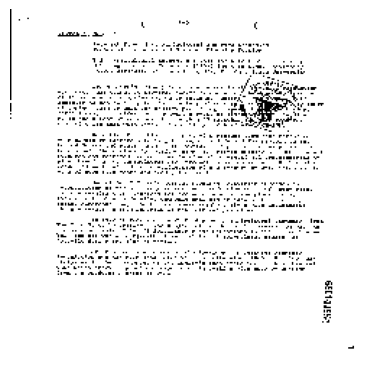

In [ ]:
# check a sample of preprocess by plotting
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(preprocess_image(x_train_file_paths[0]), cmap='gray')  # Use 'cmap' parameter if the image is grayscale
plt.axis('off')  # Turn off axis ticks and labels

# Display the plot
plt.show()


In [ ]:
x_train_labels_cut=x_train_labels[:15000]
x_test_labels_cut=x_test_labels[:3750]
x_validate_labels_cut=x_validate_labels[:3750]
train_labels_cut=train_labels[:15000]
test_labels_cut=test_labels[:3750]
validate_labels_cut=validate_labels[:3750]

In [ ]:
# import tensorflow as tf

# def create_model(input_shape):
#     # Shared layers
#     shared_model = tf.keras.models.Sequential()

#     shared_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
#     shared_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#     shared_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
#     shared_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
#     shared_model.add(tf.keras.layers.Flatten())

#     # Stamp detection branch
#     stamp_detection_model = tf.keras.models.Sequential()
#     stamp_detection_model.add(shared_model)
#     stamp_detection_model.add(tf.keras.layers.Dense(64, activation='relu'))
#     stamp_detection_model.add(tf.keras.layers.Dense(2, activation='sigmoid'))  # Modify to have 1 uni

#     # Bounding box regression branch
#     bounding_box_model = tf.keras.models.Sequential()
#     bounding_box_model.add(shared_model)
#     bounding_box_model.add(tf.keras.layers.Dense(64, activation='relu'))
#     bounding_box_model.add(tf.keras.layers.Dense(4, activation='linear'))

#     return stamp_detection_model, bounding_box_model

# # Create the model
# input_shape = (256,256,1)
# stamp_detection_model, bounding_box_model = create_model(input_shape)

# # Compile the models
# stamp_detection_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# bounding_box_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# # Print the model summaries
# stamp_detection_model.summary()
# bounding_box_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 246016)            18816     
                                                                 
 dense (Dense)               (None, 64)                15745088  
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,764,034
Trainable params: 15,764,034
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 246016)            18816     
                                                                 
 dense_2 (Dense)    

In [ ]:
import tensorflow as tf

def create_model(input_shape):
    # Shared layers
    shared_model = tf.keras.models.Sequential()
    shared_model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    shared_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    shared_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    shared_model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    shared_model.add(tf.keras.layers.Flatten())

    # Stamp detection branch
    stamp_detection_model = tf.keras.models.Sequential()
    stamp_detection_model.add(shared_model)
    stamp_detection_model.add(tf.keras.layers.Dense(64, activation='relu'))
    stamp_detection_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Output 1 unit for binary classification

    # Bounding box regression branch
    bounding_box_model = tf.keras.models.Sequential()
    bounding_box_model.add(shared_model)
    bounding_box_model.add(tf.keras.layers.Dense(64, activation='relu'))
    bounding_box_model.add(tf.keras.layers.Dense(4, activation='linear'))  # Output 4 units for (xmin, ymin, xmax, ymax)

    return stamp_detection_model, bounding_box_model

# Create the model
input_shape = (256, 256, 1)
stamp_detection_model, bounding_box_model = create_model(input_shape)

# Define the loss functions
stamp_detection_loss = tf.keras.losses.BinaryCrossentropy()
bounding_box_loss = tf.keras.losses.MeanSquaredError()

# Compile the models with appropriate loss functions
stamp_detection_model.compile(optimizer='adam', loss=stamp_detection_loss, metrics=['accuracy'])
bounding_box_model.compile(optimizer='adam', loss=bounding_box_loss, metrics=['mae'])

# Print the model summaries
stamp_detection_model.summary()
bounding_box_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 246016)            18816     
                                                                 
 dense_4 (Dense)             (None, 64)                15745088  
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 15,763,969
Trainable params: 15,763,969
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 246016)            18816     
                                                                 
 dense_6 (Dense)    

In [ ]:
# loading the model with the weights when restarting colab
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.models import Sequential

stamp_detection_model = load_model("/content/predict_if_stamp_exist2.h5")
stamp_detection_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
stamp_detection_model = load_model("/content/predict_if_stamp_exist2.h5")
bounding_box_model.compile(optimizer='adam', loss=bounding_box_loss, metrics=['accuracy'])

In [ ]:
# onehot encoding for the categorical data of the model stamp_detection_model (0 or 1 as in there is a stamp or not)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()

# Fit the label encoder on the combined train and test labels
label_encoder.fit(train_labels_cut + validate_labels_cut + test_labels_cut)

# Perform label encoding on train, validate, and test labels
train_labels_encoded = label_encoder.transform(x_train_labels_cut)
validate_labels_encoded = label_encoder.transform(x_validate_labels_cut)
test_labels_encoded = label_encoder.transform(x_test_labels_cut)
# Perform one-hot encoding on train, validate, and test labels
num_classes = len(label_encoder.classes_)  # Number of unique classes
print(num_classes)
train_labels_onehot = to_categorical(train_labels_encoded, num_classes=num_classes)
validate_labels_onehot = to_categorical(validate_labels_encoded, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels_encoded, num_classes=num_classes)
print(train_labels_onehot)


ValueError: ignored

In [ ]:
# resizing the list of coordinates to the scale 256*256 that we train the model on
import numpy as np
from skimage.transform import resize

# Sample list of coordinates


# Convert coordinates to NumPy array
coordinates_array = np.array(list_of_coordinates)

# Calculate the scaling factor
scale_factor = np.array([256 / 754, 256 / 1000, 256 / 754, 256 / 1000])

# Resize the coordinates
resized_coordinates = resize(coordinates_array, (len(list_of_coordinates), 4), order=0, anti_aliasing=False)
resized_coordinates = resized_coordinates * np.array(scale_factor)

# Print the resized coordinates
print(resized_coordinates)


[[ 41.42175066  67.072       93.70822281 106.496     ]
 [174.51458886 198.144      226.80106101 237.568     ]
 [ 44.13793103 188.672       96.42440318 228.096     ]
 ...
 [177.90981432 195.328      230.19628647 234.752     ]
 [151.4270557  158.72       203.71352785 198.144     ]
 [  1.35809019 205.568       53.64456233 244.992     ]]


In [ ]:
print(len(resized_coordinates))

45000


In [ ]:
cords_train=resized_coordinates[:30000]
cords_validate=resized_coordinates[30000:37500]
cords_test=resized_coordinates[37500:]

In [ ]:
cords_train=cords_train[15000:]
cords_validate=cords_validate[3750:]
cords_test=cords_test[3750:]

In [ ]:
np_train=np.array(cords_train)
np_test=np.array(cords_test)
np_validate=np.array(cords_validate)

In [ ]:
print(np.shape(np_train))

(15000, 4)


In [ ]:
print(len(test_labels))

4103


In [ ]:
print(encoded_cords_validate.shape)

(3750, 2906)


In [ ]:
import tensorflow as tf

# Set the global TensorFlow execution mode to eager
tf.config.experimental_run_functions_eagerly(True)

# Train the bounding box model
bounding_box_model.fit(x_train, np_train, validation_data=(x_validate, np_validate), epochs=5, batch_size=64, verbose=1)

# Reset the TensorFlow execution mode back to the default (graph mode)
tf.config.experimental_run_functions_eagerly(False)


Epoch 1/5
235/235 [==============================] - 423s 2s/step - loss: 52.5507 - mae: 5.4348 - val_loss: 39.9210 - val_mae: 4.6096
Epoch 2/5
235/235 [==============================] - 419s 2s/step - loss: 42.7324 - mae: 4.9406 - val_loss: 33.8877 - val_mae: 4.2677
Epoch 3/5
235/235 [==============================] - 422s 2s/step - loss: 27.8022 - mae: 3.9646 - val_loss: 25.7091 - val_mae: 3.7415
Epoch 4/5
235/235 [==============================] - 424s 2s/step - loss: 22.3986 - mae: 3.5968 - val_loss: 31.4164 - val_mae: 4.3211
Epoch 5/5
235/235 [==============================] - 421s 2s/step - loss: 21.5401 - mae: 3.5508 - val_loss: 26.0726 - val_mae: 3.8820


In [ ]:
# Train the stamp detection model
# stamp_detection_model.fit(x_train, train_labels_onehot, validation_data=(x_validate, validate_labels_onehot), epochs=5, batch_size=64, verbose=1)

# Train the bounding box model
bounding_box_model.fit(x_train, np_train, validation_data=(x_validate, np_validate), epochs=5, batch_size=64, verbose=1)


Epoch 1/5


ValueError: ignored

In [ ]:
bounding_box_model.save("predict_cords2.h5")

In [ ]:
# Evaluate the stamp detection model
# stamp_loss, stamp_accuracy = stamp_detection_model.evaluate(x_test, test_labels_onehot, batch_size=64, verbose=1)

# Evaluate the bounding box model
# bbox_loss, bbox_mae = bounding_box_model.evaluate(x_test, np_test, batch_size=64, verbose=1)
# Evaluate the model and obtain additional metrics
bbox_loss, bbox_mae = bounding_box_model.evaluate(x_test, np_test, batch_size=64, verbose=1)

In [ ]:
for i in stamp_detection_predictions:
  print(i)

Streaming output truncated to the last 5000 lines.
[0.5852934]
[0.53978723]
[0.6322198]
[0.58998585]
[0.6163128]
[0.5513442]
[0.579499]
[0.57606804]
[0.5824914]
[0.5343643]
[0.63415253]
[0.51569325]
[0.56030655]
[0.5543483]
[0.58712524]
[0.5094554]
[0.5667807]
[0.5895627]
[0.6476492]
[0.51694316]
[0.5506559]
[0.5707078]
[0.5515835]
[0.55746955]
[0.59886515]
[0.59557146]
[0.55889386]
[0.57381856]
[0.52917236]
[0.54050326]
[0.5533134]
[0.5600468]
[0.5688774]
[0.53731877]
[0.6760449]
[0.53628016]
[0.6096489]
[0.5589233]
[0.6249302]
[0.5492264]
[0.62359345]
[0.59093934]
[0.5886513]
[0.5401572]
[0.50538176]
[0.6128133]
[0.60071117]
[0.55738145]
[0.6565539]
[0.58257866]
[0.5537286]
[0.597086]
[0.56689507]
[0.6012816]
[0.5527016]
[0.54178035]
[0.52400833]
[0.5012536]
[0.5350977]
[0.5986851]
[0.5282825]
[0.51475734]
[0.5770813]
[0.5669257]
[0.5794023]
[0.64535403]
[0.5869732]
[0.59066707]
[0.6343155]
[0.6188088]
[0.5567626]
[0.59784436]
[0.57271785]
[0.5350198]
[0.52792776]
[0.5851992]
[0.6284

In [ ]:
# Make predictions using the stamp detection model
# stamp_detection_predictions = stamp_detection_model.predict(x_train)

# Make predictions using the bounding box model
bounding_box_predictions = bounding_box_model.predict(x_train)


 24/469 [>.............................] - ETA: 58s